## Kalman filter and LQG, LQR design with inf, fin, rec horizon toolkit

In [98]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt


In [20]:
# This is the state space (discrete-time system)
# Users can change it to their own state space

Phi = np.array([[0.9599, 0.0401, -0.4861, 0.0139],
                [0.0401, 0.9599, -0.0139, 0.4861],
                [0.1566, -0.1565, 0.9321, -0.0678],
                [0.1566, -0.1565, -0.0679, 0.9322]
                ])

Gamma = np.array([[-0.1049, 0.0017],
                  [-0.0017, 0.1049],
                  [0.4148, -0.0118],
                  [-0.0118, 0.4148]
                ])

C = np.array([
    [0.5,0.5,0,0],
    [-2.113,2.113,0.375,0.375]
])

In [21]:
def computeLQRinf(Phi, Gamma, Q1, Q2):
    S_inf = sp.linalg.solve_discrete_are(Phi, Gamma, Q1,Q2)
    K_inf = sp.linalg.pinv(Q2 + Gamma.T @ S_inf @ Gamma) @ Gamma.T @ S_inf @ Phi
    return K_inf

In [82]:
# Test computeLQRinf
import control
Q1 = 5*np.eye(4)
Q2 = 10*np.eye(2)

Rw = 1e-2*np.eye(2)
Rv = 1e-3*np.eye(2)

Kinf = computeLQRinf(Phi, Gamma, Q1, Q2)
Kinf


array([[-0.30124624, -0.216323  ,  1.00174517, -0.2153715 ],
       [ 0.21650781,  0.30126898, -0.21547217,  1.00184647]])

In [83]:
x0 = np.array([100,0,100,0])


In [108]:
N = 50 # Time step
x_l = [x0] #x_old
u_l = []
for k in range(N):
    u = -Kinf @ x_l[-1]
    u_l.append(u)
    # update state
    x = Phi @ x_l[-1] + Gamma @ u
    x_l.append(x) # replace the old state w/ the new state x
print(u)

[-0.00039333 -0.00039612]


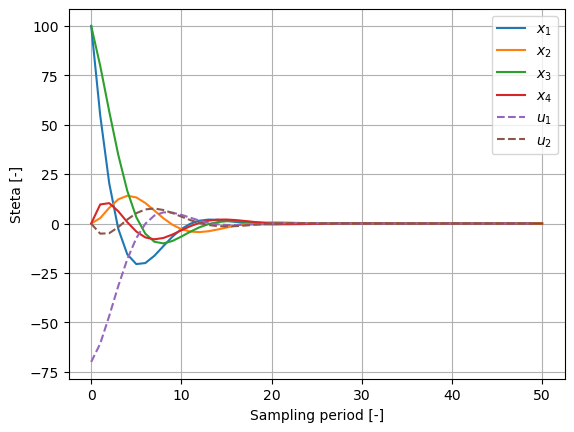

In [109]:
# plot results
x_l = np.asarray(x_l) # response
u_l = np.asarray(u_l) # control input

plt.plot(x_l[:,0], label='$x_1$') # The first state x1
plt.plot(x_l[:,1], label='$x_2$') 
plt.plot(x_l[:,2], label='$x_3$') 
plt.plot(x_l[:,3], label='$x_4$') 

plt.plot(u_l[:,0], linestyle = '--', label='$u_1$') 
plt.plot(u_l[:,1], linestyle = '--', label='$u_2$') 
plt.xlabel('Sampling period [-]')
plt.ylabel('Steta [-]')
plt.legend()
plt.grid(True)




In [111]:
# Finite horizon
def computeLQRfin(Phi_, Gamma_, Q1, Q2, N):
    # Check if Phi and Gamma callable, prevent the error.
    if not callable(Phi_):
        Phi = lambda k: Phi_ # constant function
    else:
        Phi = Phi_
 

    if not callable(Gamma_):
        Gamma = lambda k: Gamma_ # constant function
    else:
         Gamma = Gamma_
 
    
    S_l =  [Q1]
    S = lambda k: S_l[N - k]

    K_l = [ sp.linalg.pinv(Q2 + Gamma(N).T @ S(N) @ Gamma(N)) @ Gamma(N).T @ S(N) @ Phi(N) ]
    K = lambda k: K_l[N - k]

    for k in list(range(1, N+1))[::-1]: 
        R = Q2 + Gamma(k).T @ S(N) @ Gamma(k)
        M = S(k) - S(k) @ Gamma(k) @ sp.linalg.pinv(R) @ Gamma(k).T @ S(k)
        S_l.append( Phi(k).T @ M @ Phi(k) + Q1)
        K_l.append( sp.linalg.pinv(R) @ Gamma(k).T @ S(k) @ Phi(k) )


    return K

In [112]:
Kfin = computeLQRfin(Phi, Gamma, Q1, Q2, 10)
print("Kfin: ", Kfin(0))

Kfin:  [[-0.40453022 -0.27041855  1.17943841 -0.24812879]
 [ 0.2706235   0.40457178 -0.24824362  1.17958468]]


In [113]:
# receding horizon
def computeLQRrec(Phi_, Gamma_, Q1, Q2, n, N):
    """
    n: costing length
    N: total time horizon
    """
    K_l = []
    # Check if Phi and Gamma callable, prevent the error.
    if not callable(Phi_):
        Phi = lambda k: Phi_ # constant function
    else:
        Phi = Phi_
 

    if not callable(Gamma_):
        Gamma = lambda k: Gamma_ # constant function
    else:
         Gamma = Gamma_
    
    for k in range(N):
        Phi_tmp = lambda i : Phi(i + k)
        Gamma_tmp = lambda i : Gamma(i + k)

        K_tmp = computeLQRfin(Phi_tmp, Gamma_tmp, Q1, Q2, N)
        K_l.append(K_tmp(0))

    K = lambda k: K_l[k]
    
    return K

In [114]:
Krec = computeLQRrec(Phi, Gamma, Q1,Q2,10,100)
print(Krec(0))
print(Kfin(0))

[[-0.40499846 -0.27009891  1.18124904 -0.24653659]
 [ 0.27030388  0.40504072 -0.24665165  1.18139597]]
[[-0.40453022 -0.27041855  1.17943841 -0.24812879]
 [ 0.2706235   0.40457178 -0.24824362  1.17958468]]


In [115]:
# Kalman filter (LQE)
# Infinte horizon Kalman filter
def computeLQEinf(Phi, Gamma, C, Rw, Rv):
    Minf = sp.linalg.solve_discrete_are(Phi.T,C.T, Gamma @ Rw @ Gamma.T, Rv )

    Linf = Minf @ C.T @ np.linalg.pinv(C @ Minf @ C.T + Rv)

    return Linf

Linf = computeLQEinf(Phi, Gamma, C, Rw, Rv)

In [122]:
N = 50 # Time step
x_l = [x0] #x_old
xh_l = [x0] # initial state
u_l = []
y_l = [C @ x0]
for k in range(N):
    # Controller
    u = -Kinf @ xh_l[-1]
    u_l.append(u)
    # Plant
    # update state
    x = Phi @ x_l[-1] + Gamma @ u
    x_l.append(x) # replace the old state w/ the new state x

    # Noisy output
    v = np.random.normal([1e-3, 1e-3])
    v = np.zeros(2)
    y = C @ x + v

    # Current estimator
    xbar = xh_l[-1] + Linf @ (y - C @ xh_l[-1]) # previous things

    # Predictor estimator
    xhat = Phi @ xbar + Gamma @ u

    xh_l.append(xhat)

    y_l.append(y)



In [123]:
x_l = np.asarray(x_l) # response
u_l = np.asarray(u_l) # control input
# Estimator
xh_l = np.asarray(xh_l) # response


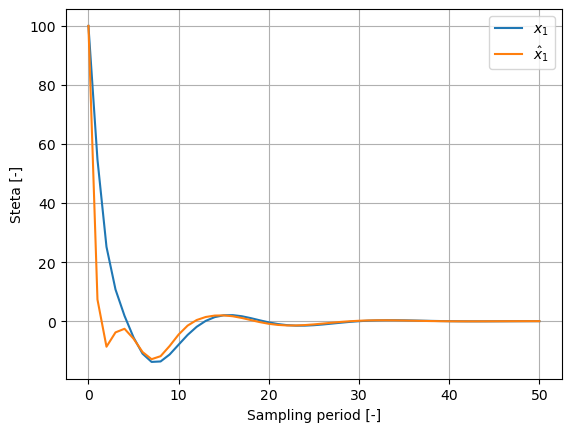

In [126]:
plt.plot(x_l[:,0], label='$x_1$') # The first state x1
plt.plot(xh_l[:,0], label=r'$\hat{x}_1$') 
# plt.plot(x_l[:,2], label='$x_3$') 
# plt.plot(x_l[:,3], label='$x_4$') 

# plt.plot(u_l[:,0], linestyle = '--', label='$u_1$') 
# plt.plot(u_l[:,1], linestyle = '--', label='$u_2$') 
plt.xlabel('Sampling period [-]')
plt.ylabel('Steta [-]')
plt.legend()
plt.grid(True)